# VGG16 の結果を再利用したい
うまくいってはないです。

## data set の読み込み
- remote から取得する


In [6]:
!wget https://kokoichi0206.mydns.jp/data/saka/akb.zip

--2022-04-16 16:36:29--  https://kokoichi0206.mydns.jp/data/saka/akb.zip
Resolving kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)... 119.106.0.95, 240f:74:c9f6:1:dea6:32ff:feb4:6b83
Connecting to kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)|119.106.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319420982 (305M) [application/zip]
Saving to: ‘akb.zip.2’

akb.zip.2           100%[===================>] 304.62M  11.2MB/s    in 28s     

2022-04-16 16:36:58 (10.9 MB/s) - ‘akb.zip.2’ saved [319420982/319420982]



In [7]:
!wget https://kokoichi0206.mydns.jp/data/saka/saka.zip

--2022-04-16 16:36:58--  https://kokoichi0206.mydns.jp/data/saka/saka.zip
Resolving kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)... 119.106.0.95, 240f:74:c9f6:1:dea6:32ff:feb4:6b83
Connecting to kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)|119.106.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251371198 (240M) [application/zip]
Saving to: ‘saka.zip.2’

saka.zip.2          100%[===================>] 239.73M  11.2MB/s    in 22s     

2022-04-16 16:37:20 (10.9 MB/s) - ‘saka.zip.2’ saved [251371198/251371198]



In [8]:
!yes | unzip akb.zip >/dev/null
!yes | unzip saka.zip >/dev/null

replace akb/濵 咲友菜/014082_0.jpg_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014022_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014023_0.jpg_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014025_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014020_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014068_0.jpg_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014068_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014053_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014056_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014073_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014001_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014045_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014033_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace akb/濵 咲友菜/014052_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: re

In [9]:
!ls

akb	 akb.zip.1  saka      saka.zip.1  sample_data
akb.zip  akb.zip.2  saka.zip  saka.zip.2


In [10]:
groups = ["akb", "saka"]

akbs = glob.glob("akb/*/*.jpg")
sakas = glob.glob("saka/*/*.jpg")
faces = []

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    with Image.open(path) as img:
        # colabでリサイズする場合
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    with Image.open(path) as img:
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
a = np.zeros((len_akbs, 1), dtype="float32")
s = np.ones((len_sakas, 1), dtype="float32")
y = np.concatenate([a, s])

(512, 512, 3)


In [11]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(10193, 64, 64, 3)
(10193, 1)
64


## model の作成・訓練

In [14]:
import glob
import gc
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as layers


In [15]:
def create_dataset(X, y, test_size=0.1, val_size=0.2, random_state=123):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=round(val_size/(1-test_size), 2), random_state=random_state)

    return X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0, X_val.astype(np.float32) / 255.0, \
            y_train.astype(np.float32), y_test.astype(np.float32), y_val.astype(np.float32)

In [16]:
X_train, X_test, X_val, y_train, y_test, y_val = create_dataset(X, y)

In [35]:
import tensorflow.keras as keras

conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False,   # 全結合層を含めるか
                                           input_shape=(64, 64, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [42]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(tf.reshape(preprocessed_images, [1,64,64,3]))
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

print(X_train.shape)
print(y_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_features, train_labels = get_features_and_labels(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_features, val_labels = get_features_and_labels(val_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape

(7154, 64, 64, 3)
(7154, 1)


(7154, 2, 2, 512)

In [46]:
import tensorflow as tf
import tensorflow.keras.layers as layers

IMG_SIZE = X.shape[1]
inputs = layers.Input(shape=(2, 2, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 2, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extractioni.keras",
                                    save_best_only=True,
                                    monitor="val_loss")
]
history = model.fit(train_features, train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
224/224 [==============================] - 4s 5ms/step - loss: 2.8697 - accuracy: 0.5029 - val_loss: 1.1333 - val_accuracy: 0.4383
Epoch 2/20
224/224 [==============================] - 1s 4ms/step - loss: 0.9311 - accuracy: 0.5315 - val_loss: 0.7902 - val_accuracy: 0.4383
Epoch 3/20
224/224 [==============================] - 1s 4ms/step - loss: 0.7077 - accuracy: 0.5484 - val_loss: 0.7499 - val_accuracy: 0.5617
Epoch 4/20
224/224 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.5457 - val_loss: 0.7162 - val_accuracy: 0.5617
Epoch 5/20
224/224 [==============================] - 1s 4ms/step - loss: 0.7060 - accuracy: 0.5471 - val_loss: 0.7492 - val_accuracy: 0.5617
Epoch 6/20
224/224 [==============================] - 1s 4ms/step - loss: 0.6990 - accuracy: 0.5506 - val_loss: 0.7415 - val_accuracy: 0.4383
Epoch 7/20
224/224 [==============================] - 1s 4ms/step - loss: 0.7012 - accuracy: 0.5474 - val_loss: 0.6969 - val_accuracy: 0.5617
Epoch 

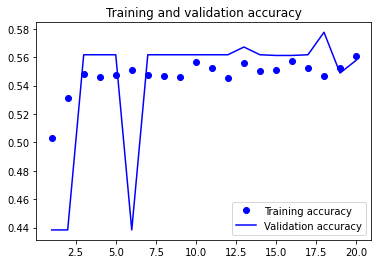

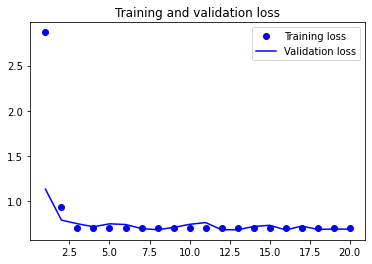

In [48]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()